In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:

# Step 1: Imports and Setup
print("Step 1 is starting")
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (Input, Dense, GlobalAveragePooling2D, 
                                     BatchNormalization, Dropout, Reshape, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra)
tf.config.optimizer.set_jit(True)
print("✅ Mixed Precision + XLA JIT Enabled")
print("Step 1 is completed")


Step 1 is starting
✅ Mixed Precision + XLA JIT Enabled
Step 1 is completed


In [9]:
# Step 2: Optimized Data Pipeline + Augmentation
print("Step 2 is starting")
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
img_size = (224, 224)

def preprocess(ds):
    return ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

root = '/kaggle/input/140k-real-and-fake-faces'
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{root}/real_vs_fake/real-vs-fake/train', 
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{root}/real_vs_fake/real-vs-fake/valid', 
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    f'{root}/real_vs_fake/real-vs-fake/test', 
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False
)

# Apply augmentation only on training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

# Class Weights
class_counts = [0, 0]
for _, labels in train_ds:
    class_counts[0] += int(tf.reduce_sum(1 - labels))
    class_counts[1] += int(tf.reduce_sum(labels))
total = sum(class_counts)
class_weights = {i: total / (2.0 * count) for i, count in enumerate(class_counts)}
print("Class weights:", class_weights)
print("Step 2 is completed")

Step 2 is starting
Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Class weights: {0: 1.0, 1: 1.0}
Step 2 is completed


In [10]:
# Step 3: Model Building with L2 Regularization--A
print("Step 3 is starting")
from tensorflow.keras.regularizers import l2

image_input = Input(shape=(224, 224, 3))
base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=image_input)

for layer in base_model.layers[:-20]:
    layer.trainable = False

se = GlobalAveragePooling2D()(base_model.output)
se = Reshape((1, 1, se.shape[1]))(se)
se = Dense(se.shape[-1] // 16, activation='relu')(se)
se = Dense(base_model.output.shape[-1], activation='sigmoid')(se)
attention_output = Lambda(lambda x: x[0] * x[1])([base_model.output, se])

x = GlobalAveragePooling2D()(attention_output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid', dtype='float32')(x)

model = Model(inputs=image_input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])
model.summary()
print("Step 3 is completed")

Step 3 is starting


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ cast_4[0][0]           │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat  

 Total params: 7,697,025 (29.36 MB)

 Trainable params: 1,025,665 (3.91 MB)

 Non-trainable params: 6,671,360 (25.45 MB)

Step 3 is completed


In [11]:
# Step 3: Model Building--B
print("Step 3 is starting")
image_input = Input(shape=(224, 224, 3))
base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=image_input)

for layer in base_model.layers[:-20]:
    layer.trainable = False

se = GlobalAveragePooling2D()(base_model.output)
se = Reshape((1, 1, se.shape[1]))(se)
se = Dense(se.shape[-1] // 16, activation='relu')(se)
se = Dense(base_model.output.shape[-1], activation='sigmoid')(se)
attention_output = Lambda(lambda x: x[0] * x[1])([base_model.output, se])

x = GlobalAveragePooling2D()(attention_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid', dtype='float32')(x)

model = Model(inputs=image_input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])
model.summary()
print("Step 3 is completed")


Step 3 is starting


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 230, 230, 3)    │              0 │ cast_6[0][0]           │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat  

 Total params: 7,697,025 (29.36 MB)

 Trainable params: 1,025,665 (3.91 MB)

 Non-trainable params: 6,671,360 (25.45 MB)

Step 3 is completed


In [12]:
# Step 4: Training Phase 1
print("Step 4 is starting")
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_auc', save_best_only=True, mode='max', verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)
print("Step 4 is completed")

Step 4 is starting
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7539 - auc: 0.8315 - loss: 0.5177
Epoch 1: val_auc improved from -inf to 0.97235, saving model to best_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 468s 268ms/step - accuracy: 0.7539 - auc: 0.8316 - loss: 0.5176 - val_accuracy: 0.8990 - val_auc: 0.9724 - val_loss: 0.2435 - learning_rate: 1.0000e-04
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8985 - auc: 0.9638 - loss: 0.2448
Epoch 2: val_auc improved from 0.97235 to 0.98374, saving model to best_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 375s 240ms/step - accuracy: 0.8985 - auc: 0.9638 - loss: 0.2448 - val_accuracy: 0.9285 - val_auc: 0.9837 - val_loss: 0.1803 - learning_rate: 1.0000e-04
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9245 - auc: 0.9782 - loss: 0.1885
Epoch 3: val_auc improved from 0.98374 to 0.98940, saving model to best_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 370s 237ms/step - accuracy: 0.92

In [13]:
# Step 5: Training
print("Step 5 is starting")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_auc", patience=2, factor=0.5, verbose=1, mode="max")

# ✅ Use .keras instead of .h5 to avoid deserialization issues
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_auc", mode="max")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

print("Step 5 is completed")


Step 5 is starting
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9440 - auc: 0.9856 - loss: 0.1566
Epoch 1: val_auc improved from 0.99697 to 0.99805, saving model to best_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 841s 397ms/step - accuracy: 0.9440 - auc: 0.9856 - loss: 0.1566 - val_accuracy: 0.9829 - val_auc: 0.9981 - val_loss: 0.0486 - learning_rate: 1.0000e-05
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9812 - auc: 0.9981 - loss: 0.0507
Epoch 2: val_auc improved from 0.99805 to 0.99909, saving model to best_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 491s 314ms/step - accuracy: 0.9812 - auc: 0.9981 - loss: 0.0507 - val_accuracy: 0.9855 - val_auc: 0.9991 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9876 - auc: 0.9992 - loss: 0.0338
Epoch 3: val_auc improved from 0.99909 to 0.99925, saving model to best_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 491s 314ms/step - accuracy: 0

In [33]:
# Step 5: Training
print("Step 5 is starting")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ✅ Callbacks
early_stop = EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_auc", patience=2, factor=0.5, verbose=1, mode="max")

# ✅ Save using .keras format to support custom ops like 'Cast'
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_auc", mode="max")

# ✅ Train (change epochs as needed)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # or use more if needed
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

print("Step 5 is completed")


Step 5 is starting
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 489s 312ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0040 - val_accuracy: 0.9934 - val_auc: 0.9996 - val_loss: 0.0180 - learning_rate: 5.0000e-06
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 490s 313ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0041 - val_accuracy: 0.9978 - val_auc: 0.9998 - val_loss: 0.0066 - learning_rate: 5.0000e-06
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 491s 313ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0039 - val_accuracy: 0.9973 - val_auc: 0.9998 - val_loss: 0.0083 - learning_rate: 5.0000e-06
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9989 - auc: 1.0000 - loss: 0.0033
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 491s 314ms/step - accuracy: 0.9989 - auc: 1.0000 - loss: 0.0033 - val_accuracy: 0.9979 - val_auc: 0.9998 - val_loss: 0.0067 - learning_rate: 5.0000e-06
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━

In [37]:
# Step 6: Evaluation
print("Step 6 is starting")

import tensorflow as tf
import keras  # Not tensorflow.keras, we need to enable unsafe deserialization here
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ✅ Enable loading Lambda layers (needed for .keras model with Lambda)
keras.config.enable_unsafe_deserialization()

# ✅ Load the saved model
model = tf.keras.models.load_model("best_model.keras")

# ✅ Recompile to ensure AUC is included
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# ✅ Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# ✅ Generate predictions
y_pred = model.predict(test_ds)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# ✅ Show classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("Step 6 is completed ✅")


Step 6 is starting
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.9966 - auc: 0.5032 - loss: 0.0098
Test Accuracy: 0.9974
Test AUC Score: 1.0000
Test Loss: 0.0071
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 109ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10000
         1.0       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Confusion Matrix:
[[9959   41]
 [  10 9990]]
Step 6 is completed ✅


In [36]:
import keras

# ✅ Allow deserializing Lambda layers
keras.config.enable_unsafe_deserialization()

# ✅ Now load the model
model = tf.keras.models.load_model("best_model.keras")

# ✅ Then recompile it
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)


Step 7 is starting


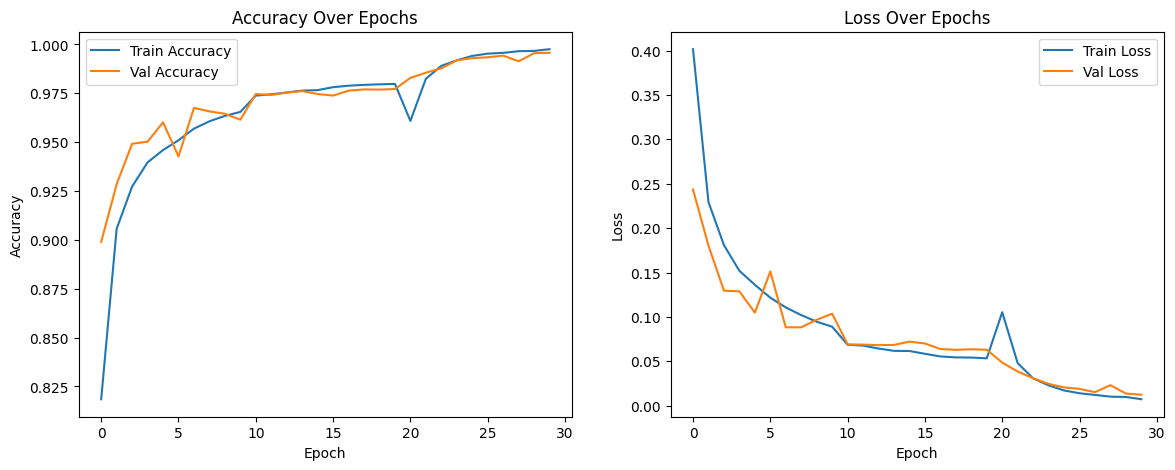

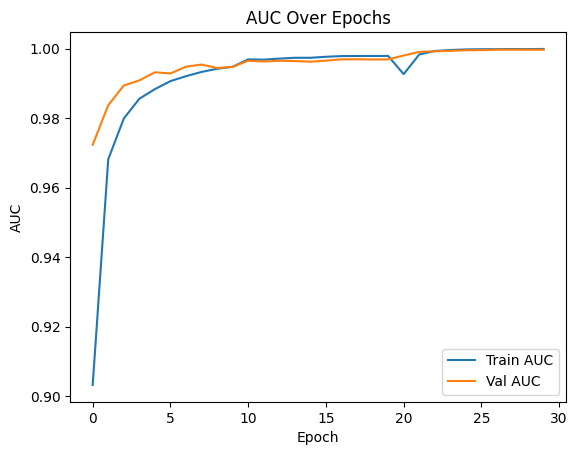

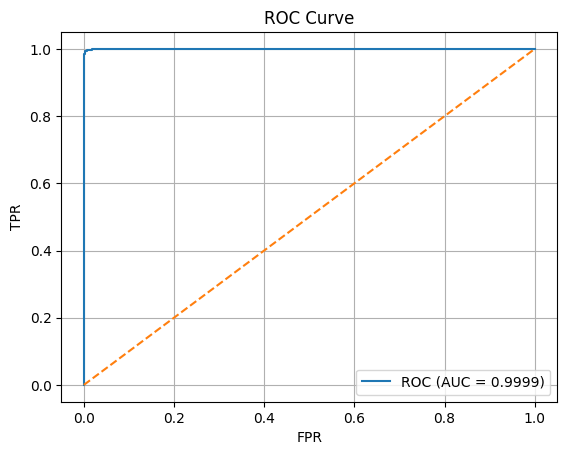

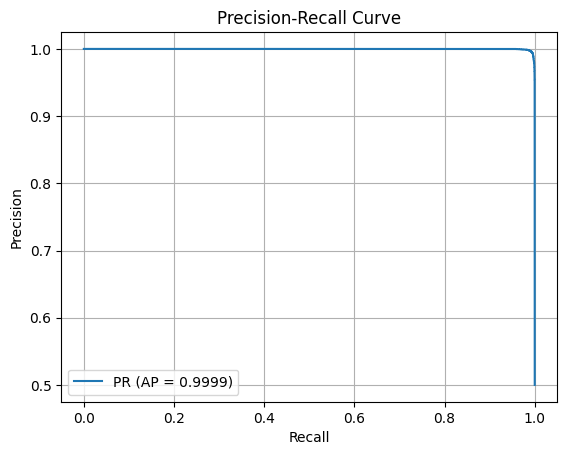

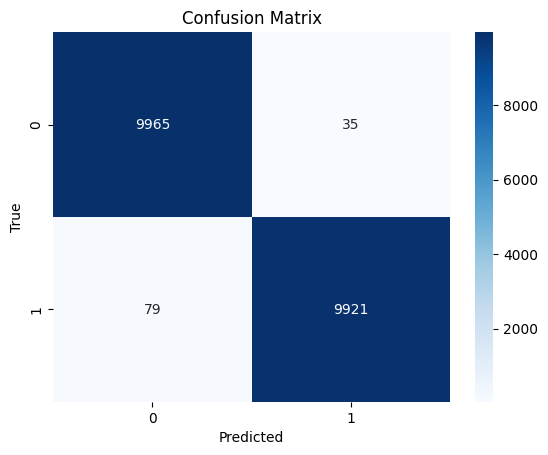

Step 7 is completed


In [15]:
# Step 7: Graphs
print("Step 7 is starting")
def combine_history(h1, h2):
    result = {}
    for key in h1.history.keys():
        result[key] = h1.history[key] + h2.history[key]
    return result

final_history = combine_history(history, history_finetune)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(final_history['auc'], label='Train AUC')
plt.plot(final_history['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_pred)
ap_score = average_precision_score(y_true, y_pred)

plt.figure()
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("Step 7 is completed")

In [16]:
# Step 8: Grad-CAM
print("Step 8 is starting")
import cv2
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='conv5_block16_concat', alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * alpha + img_array[0] * 255
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img.astype("uint8"))
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.tight_layout()
    plt.show()

print("Step 8 is completed")

Step 8 is starting
Step 8 is completed


In [17]:
# Step 9: Image Prediction
print("Step 9 is starting")
def predict_image(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    label = "Fake" if prediction > 0.5 else "Real"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")
    return label, confidence
print("Step 9 is completed")

Step 9 is starting
Step 9 is completed


In [18]:

# Step 10: Video Prediction
print("Step 10 is starting")
def predict_video_frames(video_path, model, sample_rate=30):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % sample_rate == 0:
            img = cv2.resize(frame, (224, 224))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)
            pred = model.predict(img)[0][0]
            predictions.append(pred)
        frame_count += 1
    cap.release()

    avg_pred = np.mean(predictions)
    label = "Fake" if avg_pred > 0.5 else "Real"
    confidence = avg_pred if avg_pred > 0.5 else 1 - avg_pred
    print(f"Video Prediction: {label} ({confidence*100:.2f}% confidence)")
    return label, confidence
print("Step 10 is completed")

Step 10 is starting
Step 10 is completed


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_7']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipykernel_35/2527948176.py:31: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/tmp/ipykernel_35/2527948176.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


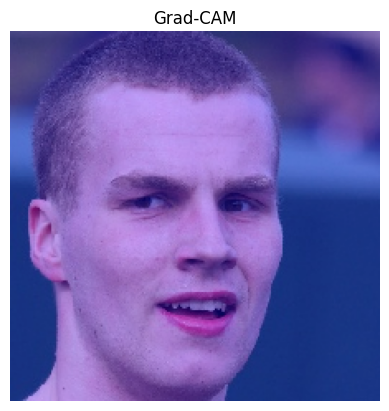

In [47]:
import tensorflow as tf
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Pick the last convolutional layer
last_conv_layer_name = "conv5_block16_2_conv"  # ⚠️ Change if you're not using DenseNet201

# ✅ Get Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# ✅ Superimpose on image
def show_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
    jet_heatmap = np.array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + np.array(img)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

show_gradcam(original_image, heatmap)


Traning EfficientB1 for Essenmble model building